In [31]:
import pandas as pd
import re
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_text
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
# Load the dataset
df = pd.read_csv("spam.csv", encoding="latin-1")

In [5]:
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Cleaning the corpus
def clean_text(text):
    text = str(text).lower() # convert text to lowercase
    text = re.sub('\\[.*?\\]','', text) # remove text in square brackets
    text = re.sub('https?://\\S+|www\\.\\S+','', text) # remove URLs
    text = re.sub('<.*?>+', '', text) # remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuations
    text = re.sub('\n', '', text) # remove new line character
    text = re.sub('\\w*\\d\\w*', '', text) # remove words containing characters
    return text 

In [17]:
df['message_clean'] = df['message'].apply(clean_text)

In [18]:
# Remove stopwords
stop_words= stopwords.words('english')
more_stopwords = ['u', 'c', 'im']
stop_words=stop_words+more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [19]:
stemmer= nltk.SnowballStemmer("english")

def stemm_text(text):
    text=' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [20]:
def preprocess_data(text):
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemming all the words 
    text=' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [21]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


In [23]:
# Encode the target variable
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

In [25]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['target'], test_size=0.2, random_state=42)

In [27]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [47]:
#X_train_tfidf.shape

(4457, 5000)

In [28]:
# SVM Model
svm_model = SVC(probability=True)  # Probability=True is needed for SHAP and LIME
svm_model.fit(X_train_tfidf, y_train)

SVC(probability=True)

In [29]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

**Model Evaluations**

In [30]:
# Predictions
svm_pred = svm_model.predict(X_test_tfidf)
nb_pred = nb_model.predict(X_test_tfidf)

# SVM Metrics
print("SVM Model Performance:")
print(classification_report(y_test, svm_pred))

# Naive Bayes Metrics
print("Naive Bayes Model Performance:")
print(classification_report(y_test, nb_pred))


SVM Model Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.99      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Naive Bayes Model Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115



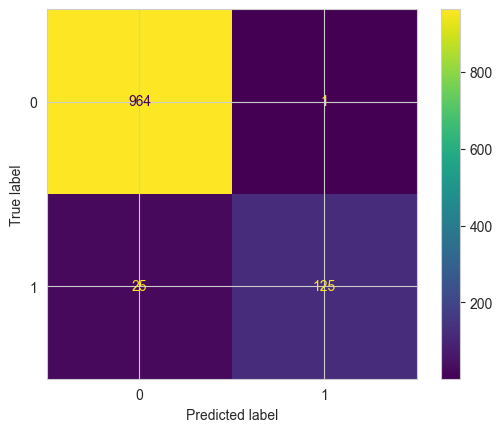

In [33]:
cm_svm = confusion_matrix(y_test, svm_pred, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, 
                              display_labels=svm_model.classes_)
disp.plot()
plt.show()

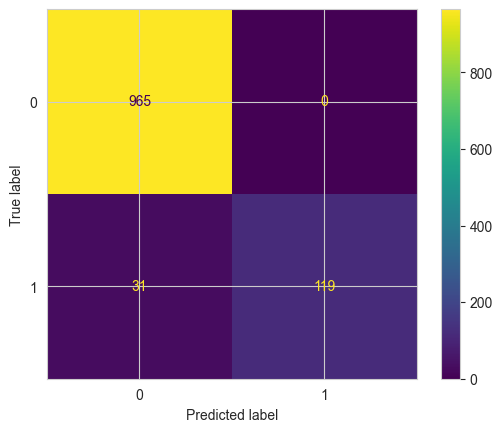

In [34]:
cm_nb = confusion_matrix(y_test, nb_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nb, 
                              display_labels=nb_model.classes_)
disp.plot()
plt.show()

In [35]:
# Small Perturbation to Test Data
X_test_perturbed = X_test.apply(lambda x: x + " free money now!!!")

# Transform
X_test_perturbed_tfidf = vectorizer.transform(X_test_perturbed)

# Predict on Perturbed Data
svm_pred_perturbed = svm_model.predict(X_test_perturbed_tfidf)
nb_pred_perturbed = nb_model.predict(X_test_perturbed_tfidf)

# Check Change in Predictions
print("SVM Drift in Prediction:", np.mean(svm_pred != svm_pred_perturbed))
print("Naive Bayes Drift in Prediction:", np.mean(nb_pred != nb_pred_perturbed))

SVM Drift in Prediction: 0.006278026905829596
Naive Bayes Drift in Prediction: 0.0026905829596412557


In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}

# Grid Search for SVM
grid_svm = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5)
grid_svm.fit(X_train_tfidf, y_train)

print("Best SVM Parameters:", grid_svm.best_params_)

Best SVM Parameters: {'C': 10, 'kernel': 'linear'}


In [48]:
# Convert sparse TF-IDF matrices to dense
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

In [54]:
# Use a larger background sample for better estimation (e.g., 100 samples)
background_sample = shap.sample(X_train_dense, 100)

# Initialize KernelExplainer
explainer = shap.KernelExplainer(svm_model.predict_proba, background_sample)

# Compute SHAP values (for a subset of test data to save time)
shap_values = explainer.shap_values(X_test_dense[:100])  # Limit to 500 samples if data is too large

# Plot SHAP summary
shap.summary_plot(shap_values, X_test_dense[:100]w)

  1%|          | 1/100 [03:01<4:59:54, 181.76s/it]


KeyboardInterrupt: 

In [38]:
explainer = lime.lime_text.LimeTextExplainer(class_names=['ham', 'spam'])

i = 5  # Example message index
exp = explainer.explain_instance(X_test.iloc[i], svm_model.predict_proba, num_features=6)
exp.show_in_notebook()

ValueError: could not convert string to float: "I'll text carlos and let you know, hang on"

In [40]:
# Cohen's H Calculation
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# Simulate new data drift by adding random noise
X_new = X_test.apply(lambda x: x + " free crypto")
X_new_tfidf = vectorizer.transform(X_new)

# New Predictions
y_new_pred = svm_model.predict(X_new_tfidf)

# Calculate drift
p_old = np.mean(svm_pred)
p_new = np.mean(y_new_pred)

drift_score = cohens_h(p_old, p_new)
print(f"Cohen's H Score (SVM): {drift_score:.4f} (Drift detected if > 0.1)")


Cohen's H Score (SVM): -0.0306 (Drift detected if > 0.1)
